In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

#astropy coorindates/units
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

### Pandas
import pandas as pd

### fitting
import statsmodels.api as sm

### PCA
from sklearn.decomposition import PCA, KernelPCA

### Model generation
import itertools as it

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
import MagellanicStream as ms

# ### Functions used in this code
import age_functions as afunc

### Stuff Writtten by A Really Cool Professor
import dlnpyutils as dlpu

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

### Age of Universe
H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [2]:
###################
### Import Data ###
###################

# parsec
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/LMC_Ages/parsec3_3.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

eagb = parsecall[np.where(parsecall['label']==7)]

cheb = parsecall[np.where((parsecall['label']>=4)&(parsecall['label']<=6))]


# r13
r13 = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/lmc_rgbmembers.r13-l33-58672.fits.gz')
cln = np.where((r13['FE_H']>-9999.0)&(r13['AK_TARG']>-100.0)&(r13['LOGG']>=0.0)&
                (r13['M_H_ERR']>-100.0)&(r13['C_FE']>-100.0)&(r13['N_FE']>-100.0))
r13 = r13[cln]

# APOKASC
kasc = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/APOKASC_cat_v6.6.1.fits.gz')

# astroNN
aNN = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/apogee_astroNN-DR16.fits')
aNN = aNN[cln]

# Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/LMC_DR16_all_PDF.fits.gz', 1)
_, r13_ind, pdfout_ind = np.intersect1d(r13['APOGEE_ID'],pdfout['OBJ'],return_indices=True)

In [3]:
age = fits.getdata('/Users/joshpovick/Desktop/Research/LMC_Ages/pca_ols_ages.fits')

_, r13_ind, aNN_ind = np.intersect1d(r13['APOGEE_ID'],aNN['apogee_id'],return_indices=True)
lrgb = r13[r13_ind]
laNN = aNN[aNN_ind]
lage = age[r13_ind]

In [4]:
###############################
### Some Calcuations Needed ###
###############################

### Convert RA DEC to MS L B
c_icrs = SkyCoord(ra=r13['RA']*u.degree, dec=r13['DEC']*u.degree)
c_ms = c_icrs.transform_to(ms.MagellanicStream)
ms_lg,ms_bg = c_ms.MSLongitude.degree, c_ms.MSLatitude.degree

for i in range(len(ms_lg)):
    if ms_lg[i]-360<-180:
        ms_lg[i] += 360.0

### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

<font size='20'>
    <b>
        Salaris
    </b>
<font>

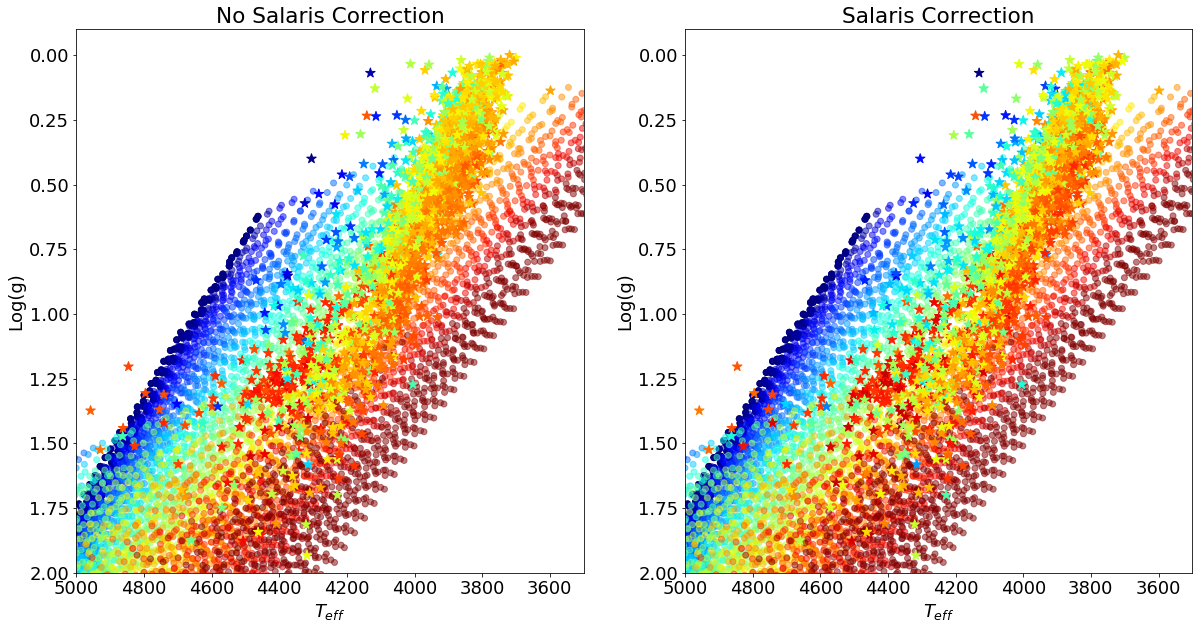

In [5]:
feh = afunc.sal(r13['M_H'],r13['ALPHA_M'])

plt.figure(figsize=[20,10])

plt.subplot(121)
plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=0.5,zorder=1)
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
plt.xlim(3500,5000)
plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('No Salaris Correction')

plt.subplot(122)
plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=0.5,zorder=1)
plt.scatter(r13['TEFF'],r13['LOGG'],c=feh,cmap='jet',marker='*',zorder=2,s=100)
plt.xlim(3500,5000)
plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('Salaris Correction')
plt.show()

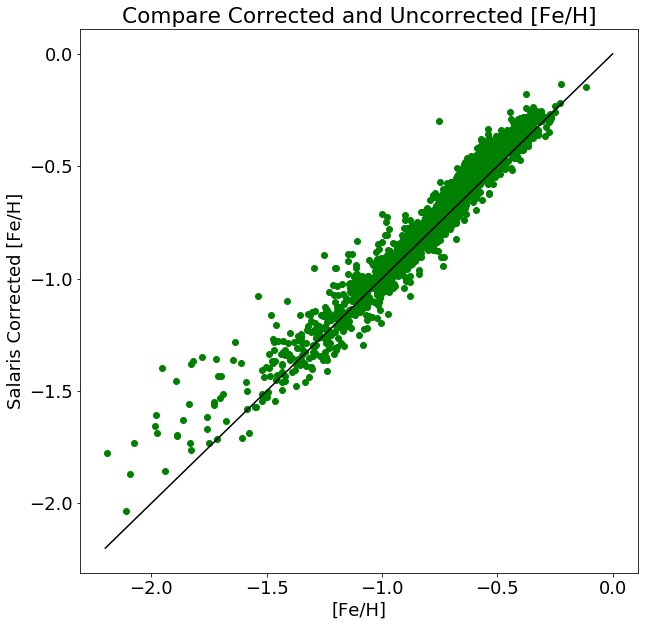

In [6]:
plt.figure(figsize=[10,10])
plt.scatter(r13['FE_H'],feh,c='g')
plt.plot([-2.2,0.0],[-2.2,0.0],c='k')
plt.xlabel(r'[Fe/H]')
plt.ylabel(r'Salaris Corrected [Fe/H]')
plt.title('Compare Corrected and Uncorrected [Fe/H]')
plt.show()

<font size='5'>
    <b>
        Fit PARSEC MH 10**logTe to get APOGEE LOGG
    </b>
<font>

In [7]:
### Find all models

#transform data to new basis
pdata = np.array([parsec['MH'],10**parsec['logTe']]).T

#create new variables

# linear terms
x1 = pdata[:,0]
x2 = pdata[:,1]

# linear int
# x12 = np.multiply(x1,x2)

# squares
x1sq = x1**2
x2sq = x2**2

# cubes
x1cu = x1**3
x2cu = x2**3

#find all possible models
models = []
models_str = []

all_var_str = ['x1','x2']#,'x1sq','x2sq','x1cu','x2cu']
all_var = [x1,x2]#,x2sq,x1cu,x2cu]

for i in range(1,len(all_var)+1):
    for subset in it.combinations(all_var,i):
        models.append(subset)
    for subset_str in it.combinations(all_var_str,i):
        models_str.append(np.array(subset_str))
        
models = np.array(models)
models_str = np.array(models_str)

### Fit All Models

import statsmodels.api as sm 

all_params = []
summaries = []
max_resid = []
mads = []
resids = []
predict = []
ll = []
aics = []
redchi = []
for i in tqdm_notebook(range(len(models)),desc='Done?'):
    pmodl = np.array(models[i]).T
    pmodl = sm.add_constant(pmodl)
    model = sm.OLS(parsec['logg'],pmodl).fit()
    summaries.append(model.summary())
    predictions = model.predict(pmodl)
    predict.append(predictions)
    residual = predictions - parsec['logg']
    resids.append(residual)
    all_params.append(np.asarray(model.params))
    max_resid.append(np.max(np.absolute(residual)))
    mads.append(afunc.mad(residual))
    ll.append(model.llf)
    aics.append(-2*model.llf+2.*((len(parsec['logg'])-len(models[i]))+1))
    redchi.append((sum((-1*residual)**2))/(len(parsec['logg'])-len(models[i])))

In [8]:
print(summaries[np.asarray(mads).argmin()])
print(models_str[np.asarray(mads).argmin()])
print(all_params[np.asarray(mads).argmin()])

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 8.216e+04
Date:                Fri, 26 Jun 2020   Prob (F-statistic):               0.00
Time:                        11:58:57   Log-Likelihood:                 2192.2
No. Observations:               14946   AIC:                            -4378.
Df Residuals:                   14943   BIC:                            -4356.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.9849      0.020   -299.357      0.0

In [9]:
def grav(temp,iron):
    p = [-5.98487734e+00,5.90744326e-01,1.80263986e-03]
    return p[0]+iron*p[1]+temp*p[2]

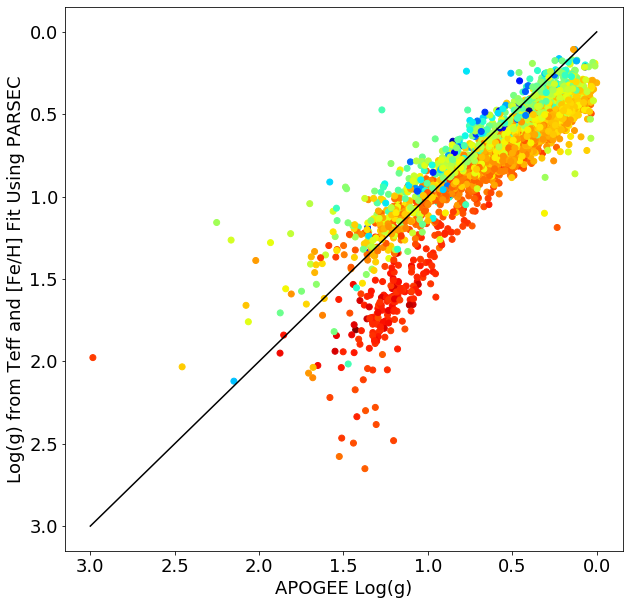

In [10]:
plt.figure(figsize=[10,10])
plt.scatter(r13['LOGG'],grav(r13['TEFF'],r13['FE_H']),c=r13['FE_H'],cmap='jet')
plt.plot([0,3],[0,3],c='k')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('APOGEE Log(g)')
plt.ylabel('Log(g) from Teff and [Fe/H] Fit Using PARSEC')
plt.show()

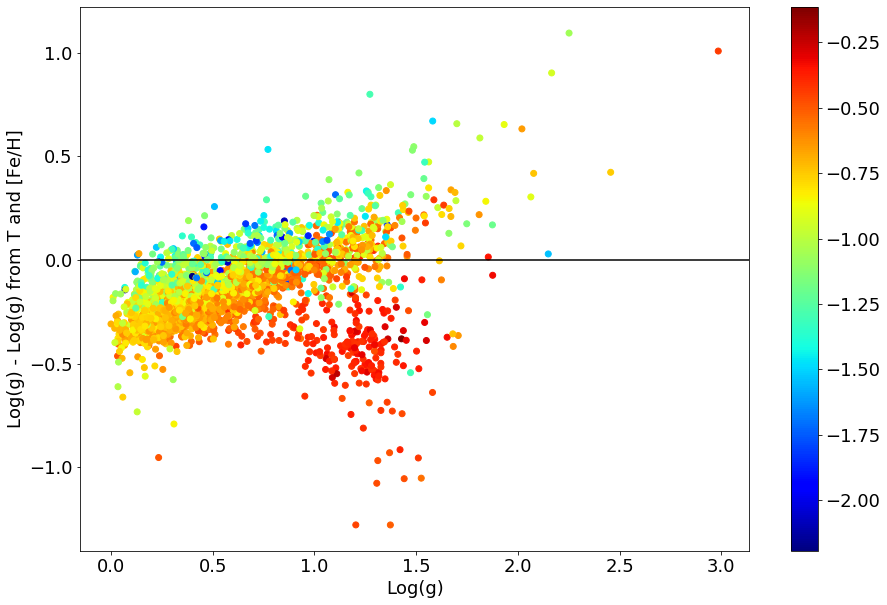

In [11]:
plt.figure(figsize=[15,10])
plt.scatter(r13['LOGG'],r13['LOGG']-grav(r13['TEFF'],r13['FE_H']),c=r13['FE_H'],cmap='jet')
plt.colorbar()
plt.ylabel(r'Log(g) - Log(g) from T and [Fe/H]')
plt.xlabel(r'Log(g)')
plt.axhline(0,c='k')
plt.show()

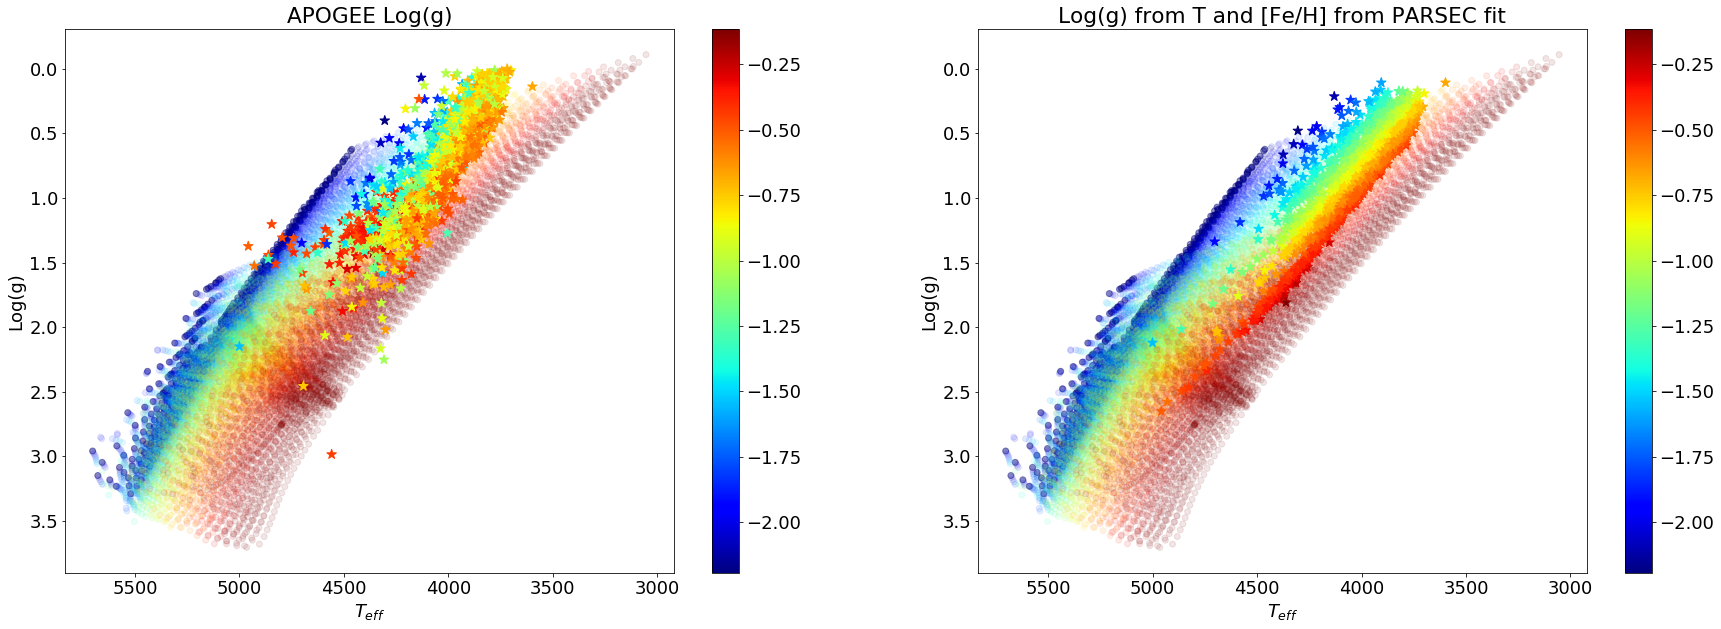

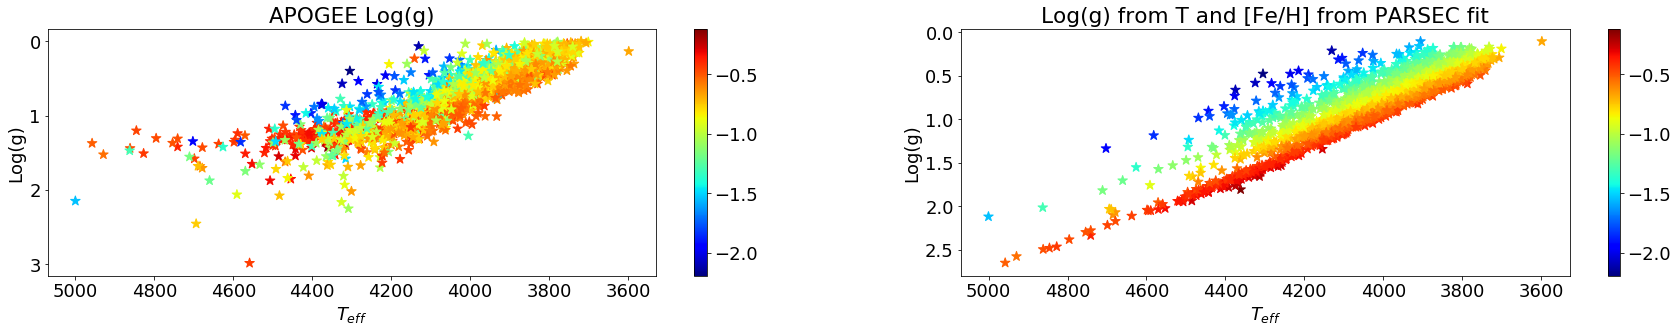

In [12]:
plt.figure(figsize=[30,10])

plt.subplot(121)
plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=0.1,zorder=1)
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
cbar = plt.colorbar()
# cbar.set_label('[Fe/H]', rotation=270)

# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('APOGEE Log(g)')

plt.subplot(122)
plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=0.1,zorder=1)
plt.scatter(r13['TEFF'],grav(r13['TEFF'],r13['FE_H']),c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
cbar = plt.colorbar()
# cbar.set_label('[Fe/H]', rotation=270)

# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('Log(g) from T and [Fe/H] from PARSEC fit')
plt.show()


plt.figure(figsize=[30,10])
plt.subplot(223)
# plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
#             cmap='jet',alpha=1.0,zorder=1)
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
cbar = plt.colorbar()
# cbar.set_label('[Fe/H]', rotation=270)
# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('APOGEE Log(g)')

plt.subplot(224)
# plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
#             cmap='jet',alpha=1.0,zorder=1)
plt.scatter(r13['TEFF'],grav(r13['TEFF'],r13['FE_H']),c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
cbar = plt.colorbar()
# cbar.set_label('[Fe/H]', rotation=270)
# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('Log(g) from T and [Fe/H] from PARSEC fit')

plt.show()

In [13]:
r13['FPARAM'][1000][1]
# print(r13['LOGG'][1000])

0.35462

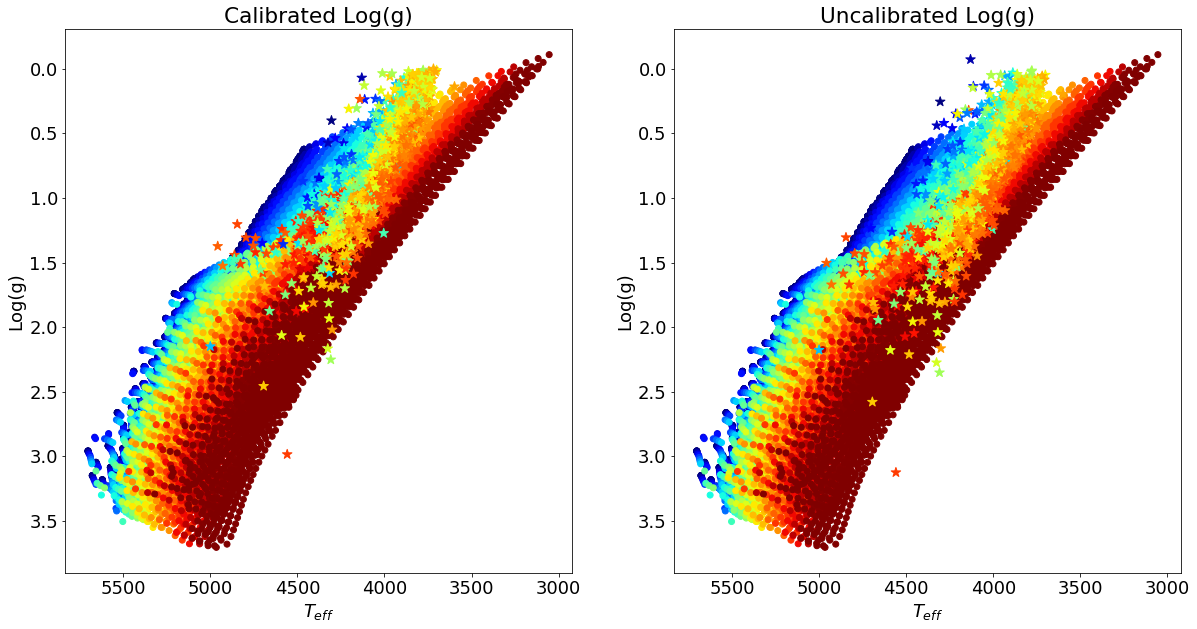

In [14]:
flogg = []
for i in range(len(r13)):
    flogg.append(r13['FPARAM'][i][1])
    
    
plt.figure(figsize=[20,10])

plt.subplot(121)
plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=1.0,zorder=1)
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('Calibrated Log(g)')
    
plt.subplot(122)
plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=1.0,zorder=1)
plt.scatter(r13['TEFF'],flogg,c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('Uncalibrated Log(g)')
plt.show()

In [15]:
min(set(parsec['MH']))

-2.19174

In [16]:
# parsec[np.where(parsec['MH']==-2.19174)]['logg'].argmin()
parsec[np.where(parsec['MH']==-2.19174)]['logTe'][454]

3.6496

Text(0.5, 1.0, 'Calibrated Log(g)')

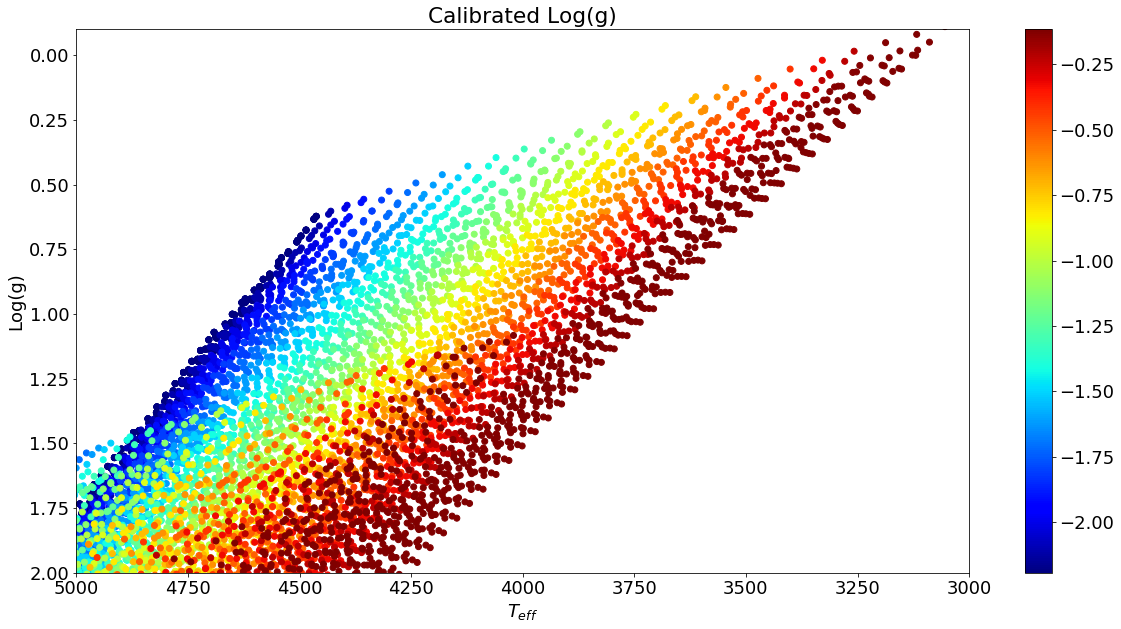

In [17]:
plt.figure(figsize=[20,10])

plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=1.0,zorder=1)
# plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
plt.colorbar()
plt.xlim(3000,5000)
plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
plt.title('Calibrated Log(g)')

In [18]:
def p_TRGB(temp):
    slope = (0.623+0.11)/(3.6496-3.4849)
    inter = 
    return

SyntaxError: invalid syntax (<ipython-input-18-0a2eda0c3e2a>, line 3)

In [18]:
plt.figure(figsize=[10,10])
plt.scatter(10**pagb['logTe'],pagb['logg'],c=pagb['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=1.0,zorder=1)
# plt.scatter(kasc['KIC_TEFF'],kasc['KIC_LOGG'],marker='*',zorder=1,s=100)
plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',zorder=2,s=100)
plt.xlim(3500,5000)
plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
# plt.title('Calibrated Log(g)')
plt.show()

NameError: name 'pagb' is not defined

<Figure size 720x720 with 0 Axes>

In [ ]:
plt.figure(figsize=[10,10])
plt.scatter(10**eagb['logTe'],eagb['logg'],c='k',vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=1.0,zorder=1)
plt.scatter(10**parsec['logTe'],parsec['logg'],c='r',vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
            cmap='jet',alpha=1.0,zorder=2)
plt.scatter(r13['TEFF'],r13['LOGG'],c='g',zorder=3,s=100)
plt.xlim(3500,5000)
plt.ylim(-0.1,2)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel(r'$T_{eff}$')
plt.ylabel(r'Log(g)')
# plt.title('Calibrated Log(g)')
plt.show()

In [ ]:
parsec.columns

In [ ]:
plt.scatter(parsec['Xc']/parsec['X'],parsec['Xo']/parsec['X'],zorder=2)
plt.scatter(pagb['Xc']/pagb['X'],pagb['Xo']/pagb['X'],zorder=1)
# plt.xlim(0.1,0.75)

In [ ]:
# ### Find all models

# #transform data to new basis
# rdata = np.array([r13['FE_H'],r13['TEFF']]).T

# #create new variables

# # linear terms
# x1 = rdata[:,0]
# x2 = rdata[:,1]

# # linear int
# # x12 = np.multiply(x1,x2)

# # squares
# x1sq = x1**2
# x2sq = x2**2

# # cubes
# x1cu = x1**3
# x2cu = x2**3

# #find all possible models
# models = []
# models_str = []

# all_var_str = ['x1','x2']#,'x1sq','x2sq','x1cu','x2cu']
# all_var = [x1,x2]#,x2sq,x1cu,x2cu]

# for i in range(1,len(all_var)+1):
#     for subset in it.combinations(all_var,i):
#         models.append(subset)
#     for subset_str in it.combinations(all_var_str,i):
#         models_str.append(np.array(subset_str))
        
# models = np.array(models)
# models_str = np.array(models_str)

# ### Fit All Models

# import statsmodels.api as sm 

# all_params = []
# summaries = []
# max_resid = []
# mads = []
# resids = []
# predict = []
# ll = []
# aics = []
# redchi = []
# for i in tqdm_notebook(range(len(models)),desc='Done?'):
#     pmodl = np.array(models[i]).T
#     pmodl = sm.add_constant(pmodl)
#     model = sm.OLS(r13['LOGG'],pmodl).fit()
#     summaries.append(model.summary())
#     predictions = model.predict(pmodl)
#     predict.append(predictions)
#     residual = predictions - r13['LOGG']
#     resids.append(residual)
#     all_params.append(np.asarray(model.params))
#     max_resid.append(np.max(np.absolute(residual)))
#     mads.append(afunc.mad(residual))
#     ll.append(model.llf)
#     aics.append(-2*model.llf+2.*((len(r13['LOGG'])-len(models[i]))+1))
#     redchi.append((sum((-1*residual)**2))/(len(r13['LOGG'])-len(models[i])))

In [ ]:
# print(summaries[np.asarray(mads).argmin()])
# print(models_str[np.asarray(mads).argmin()])
# print(all_params[np.asarray(mads).argmin()])


In [ ]:
# def modisograv(temp,iron):
#     p = [-6.69880341e+00,2.54033845e-01,1.87868410e-03]
#     return p[0]+iron*p[1]+temp*p[2]

In [ ]:
# plt.figure(figsize=[20,10])

# plt.subplot(121)
# plt.scatter(10**parsec['logTe'],parsec['logg'],c=parsec['MH'],vmin=min(r13['FE_H']),vmax=max(r13['FE_H']),
#             cmap='jet',alpha=0.5,zorder=1)
# plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.xlabel(r'$T_{eff}$')
# plt.ylabel(r'Log(g)')
# # plt.title('No Salaris Correction')

# plt.subplot(122)
# plt.scatter(10**parsec['logTe'],modisograv(10**parsec['logTe'],parsec['MH']),c=parsec['MH'],vmin=min(r13['FE_H']),
#             vmax=max(r13['FE_H']),cmap='jet',alpha=0.5,zorder=1)
# plt.scatter(r13['TEFF'],r13['LOGG'],c=r13['FE_H'],cmap='jet',marker='*',zorder=2,s=100)
# plt.xlim(3500,5000)
# plt.ylim(-0.1,2)
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.xlabel(r'$T_{eff}$')
# plt.ylabel(r'Log(g)')
# # plt.title('Salaris Correction')
# plt.show()